In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape, Flatten, ZeroPadding2D
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from simple_movement import DataGen, SimpleMovement

Using TensorFlow backend.


In [2]:
BASE_PATH = 'C:\\Users\\ttanj\\UoB\\WS18\\DBM\\data\data_simple_movement'
HEIGHT = 100
WIDTH = 100
NUM_CHANNEL = 2
RGB = 0

In [3]:
def mmc(x):
    df = 1 / 5
    w = np.array([
        [1, df, 0], [-1, 0, 1], [0, 0, 1]
    ])
    return K.dot(x, K.constant(w))

In [5]:
input_img = Input(shape=(HEIGHT, WIDTH, NUM_CHANNEL))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(1, (3, 3), activation='relu')(x)

x = Reshape((3*3*1,))(x)
x = Dense(3, activation='relu')(x)
x = Lambda(mmc)(x)
x = Dense(3*3*1, activation='relu')(x)
x = Reshape((3, 3, 1))(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = ZeroPadding2D((1, 1))(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 2)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 100, 16)      304       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 8)         584       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 8)         0         
__________

In [6]:
dgen = DataGen(HEIGHT, WIDTH, NUM_CHANNEL)
x, y = dgen.prepare_data()

x = x / 255.
y = y / 255.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True)

autoencoder.fit(x_train, y_train,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, y_test))

Train on 194 samples, validate on 22 samples
Epoch 1/100
194/194 [==============================] - 16s 84ms/step - loss: 0.6890 - val_loss: 0.6840
Epoch 2/100
194/194 [==============================] - 11s 57ms/step - loss: 0.6798 - val_loss: 0.6748
Epoch 3/100
194/194 [==============================] - 11s 57ms/step - loss: 0.6707 - val_loss: 0.6659
Epoch 4/100
194/194 [==============================] - 11s 56ms/step - loss: 0.6619 - val_loss: 0.6572
Epoch 5/100
194/194 [==============================] - 12s 63ms/step - loss: 0.6531 - val_loss: 0.6485
Epoch 6/100
194/194 [==============================] - 12s 61ms/step - loss: 0.6445 - val_loss: 0.6399
Epoch 7/100
194/194 [==============================] - 14s 70ms/step - loss: 0.6361 - val_loss: 0.6315
Epoch 8/100
194/194 [==============================] - 12s 60ms/step - loss: 0.6277 - val_loss: 0.6234
Epoch 9/100
194/194 [==============================] - 12s 64ms/step - loss: 0.6196 - val_loss: 0.6153
Epoch 10/100
194/194 [======

In [7]:
decoded_imgs = autoencoder.predict(x_test)

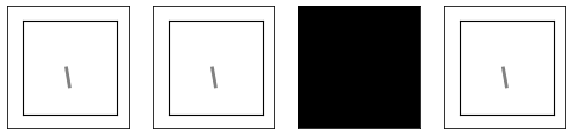

In [8]:
idx = 5

plt.figure(figsize=(10, 3))

# display original
ax = plt.subplot(1, 4, 1)
plt.imshow(x_test[idx][:, :, 0].reshape(HEIGHT, WIDTH))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 2)
plt.imshow(x_test[idx][:, :, 1].reshape(HEIGHT, WIDTH))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# display reconstruction
ax = plt.subplot(1, 4, 3)
plt.imshow(decoded_imgs[idx][:, :, 0].reshape(HEIGHT, WIDTH))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 4)
plt.imshow(y_test[idx][:, :, 0].reshape(HEIGHT, WIDTH))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()